In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json
import os
import sys
sys.path.append("../lib")
from dataUtils import *
import cPickle as pickle
import cv2
from collections import Counter
from scipy.interpolate import UnivariateSpline


In [2]:
#ClassFile = "../Logs/classes.json"
ClassFile = "../Logs/english_label.txt"

#vineScores = "../Logs/sampled_vine_sentibank_final.csv"
vineScores = "../Logs/MVSO_fine_vine_probs.csv"
#selfieScores = "../Logs/selfieSentibankProbs.csv"
sentibank_scores = "../Logs/sentibank_baseline_final.csv"

#vineANPs = "../Logs/sampled_vine_ANPS_final.pk"
vineANPs = "../Logs/MVSO_fine_vine_ANPs.pk"
#selfiePaths = "../Logs/selfiePaths.txt"

imageNetObjs = "../Logs/sampledvineImagenetObjs2015_1.pk"

#selfiePopularityFile = "../Logs/selfie_dataset.txt"

root = "../vinedata/Data/"

visitedList = "../Logs/sampledVids.data"

postFile = "../Logs/postsMapping.csv"

# sentimentFile = "../Logs/ANP_Sentiments.txt"

color_features = "../Logs/vine_features_ordered.csv"

sampled_img_list = "../Logs/sampled_sentibank_image.txt"

revisedSentimentFile = "../Logs/revised_ANP_sentiments.csv"

In [3]:
#Load the Sentibank scores for Vines
vineProbs = np.loadtxt(vineScores, delimiter=',')


In [4]:
#Load the Sentibank scores for Baseline
sentibank_baseline = np.loadtxt(sentibank_scores, delimiter=',')

In [5]:
print vineProbs.shape , sentibank_baseline.shape

(138256, 4342) (5000, 2089)


In [6]:
def get_ANP_ID_List(pickleList):
    ANPs = []
    IDs = []
    for line in pickleList:
        ids = line.split(',')[0].split('/')[5].split('_')[0]
        IDs.append(ids)
        ANPs.append(line.split(',')[1])
    return IDs , ANPs

def get_vid_senti(pickle , index):
    oldId = pickle[index].split(',')[0].split('/')[6].split('_')[0]
    seqDict = dict()
    indexList = []
    sequence = pickle[index].split(',')[0].split('/')[6].split('_')[1].split('.')[0]
    seqDict[int(sequence)] = str(pickle[index].split(',')[1])
    indexList.append(index)
    index+=1
    #print index
    while (index < len(pickle) and (pickle[index].split(',')[0].split('/')[6].split('_')[0] == oldId)):
        sequence = pickle[index].split(',')[0].split('/')[6].split('_')[1].split('.')[0]
        seqDict[int(sequence)] = str(pickle[index].split(',')[1])
        indexList.append(index)
        index += 1
    seqDict['indexList'] = indexList
    return seqDict , oldId , index

#This function maps each video with a dictionary entry that has list of all ANPS per frame
#and an index list to find them
def get_VID_ANP_List(pickle):
    megaDict = dict()
    i = 0
    print len(pickle)
    while i < len(pickle):           
        subDict , postId , i = get_vid_senti(pickle , i)
        megaDict[int(postId)] = subDict
    return megaDict


def pruneMegaDict(megadict , filterindices):
    filteredList = dict()
    for entry in megadict:
        commns = set(megadict[entry]['indexList']).intersection(filterindices)
        if len(commns) >= 6:
            filteredList[entry] = megadict[entry]
    return filteredList

def readJson(path):
    f = open(path)
    data = json.loads(f.read())
    return data


In [7]:
image_list =[]
with open(sampled_img_list) as f:
    image_list = f.readlines()

true_labels = []
for line in image_list:
    label = line.split('/')[5]
    true_labels.append(label)
    
# f = open(ClassFile ,'r')
# sentibankClasses = json.load(f)
# f.close()

f = open(ClassFile ,'r')
sentibankClasses = f.readlines()
f.close()

In [8]:
sentibank_probs = np.zeros(len(sentibank_baseline))
detected_labels = []
for i in range(sentibank_probs.shape[0]):
    sentibank_probs[i] = sentibank_baseline[i].max()
    detected_labels.append(str(sentibankClasses[np.argmax(sentibank_baseline[i])]))
    
print np.median(sentibank_probs), sentibank_probs.var(), sentibank_probs.mean()

0.0718716159463 0.0234088881327 0.125452709451


In [9]:
maxVecs = np.zeros(len(vineProbs))
for i in range(len(vineProbs)):
    maxVecs[i] = np.max(vineProbs[i])
print np.mean(maxVecs) , np.median(maxVecs) , np.var(maxVecs)

0.0214652778476 0.0156120234169 0.000478212839106


In [10]:
curatedProbs_index = []
for i in range(len(vineProbs)):
    if (vineProbs[i].max() > (np.mean(maxVecs) + np.var(maxVecs) )):
        curatedProbs_index.append(i)

        
print len(curatedProbs_index)

42985


In [11]:

vineList = readLists(vineANPs)
objList = readLists(imageNetObjs)
print curatedProbs_index[5]
print objList[1]

24
/datasets/sagarj/vineData/sampledFrames/1281860887099457536_2.jpg,label,television,


In [12]:
print vineList[0].split(',')[0].split('/')[6].split('_')[0]

1000521578741956608


In [13]:
idList, anpList = get_ANP_ID_List(vineList)

In [14]:
#print idList[1000] , anpList [1000]

In [15]:
sentidict0 = readSentiments()
sentidict = readRevisedSentiments()

In [16]:
sentiArray = []
for k in sentidict:
    sentiArray.append(sentidict[k])
print len(sentiArray)

4421


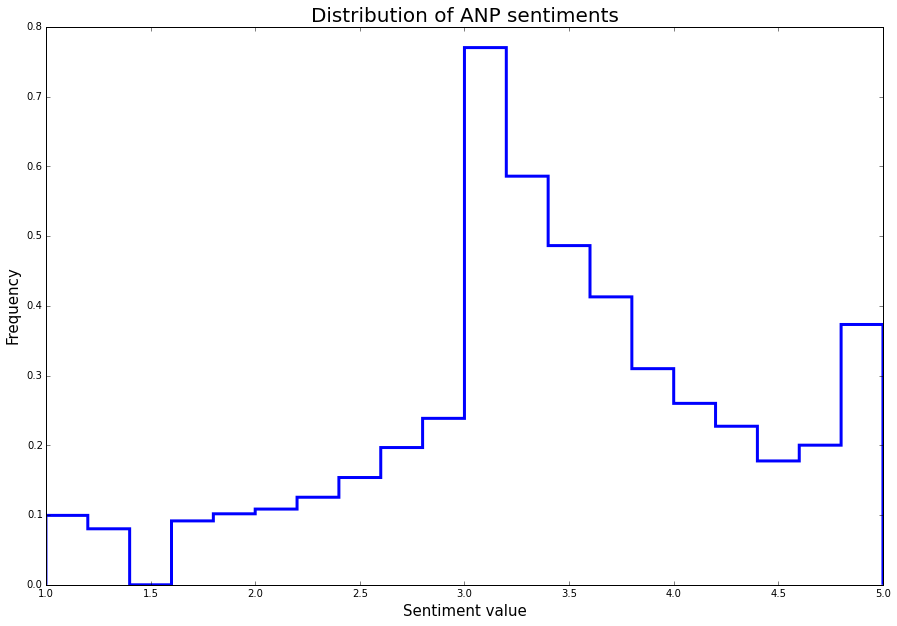

In [17]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.hist(sentiArray, 20, normed=1,histtype='step', cumulative=False,linewidth = 3.0)
plt.title("Distribution of ANP sentiments", fontsize = 20)
plt.xlabel("Sentiment value",fontsize = 15)
plt.ylabel("Frequency",fontsize = 15)
plt.show()

In [18]:
# f = open('sentibankANP.csv', 'wb')
# for k,v in sentidict0.iteritems():
#     f.write(k+','+str(v)+'\n')
#     #print k , v
# f.close()

In [19]:
megaDict = get_VID_ANP_List(vineList)

138256


In [20]:
print megaDict[1281867050901532672]
videoSentimentIndices = megaDict[1281867050901532672]['indexList']
for i in videoSentimentIndices:
    print vineList[i]

{1: 'crazy_face', 2: 'crazy_face', 3: 'sexy_lips', 4: 'big_glasses', 5: 'blurry_vision', 6: 'old_phone', 7: 'blurry_vision', 8: 'blurry_vision', 9: 'hot_boys', 10: 'hot_boys', 11: 'crazy_face', 12: 'crazy_face', 13: 'crazy_face', 'indexList': [54957, 54958, 54959, 54960, 54961, 54962, 54963, 54964, 54965, 54966, 54967, 54968, 54969]}
/datasets/sagarj/vineData/Dataset/fineSamples/1281867050901532672_10.jpg,hot_boys,0.0119556,crazy_face,0.0107386,big_glasses,0.00758053,simple_man,0.00749146,missing_person,0.00716004
/datasets/sagarj/vineData/Dataset/fineSamples/1281867050901532672_11.jpg,crazy_face,0.0161646,hot_boys,0.0117489,nice_shirt,0.00931449,big_glasses,0.00877171,simple_man,0.00853535
/datasets/sagarj/vineData/Dataset/fineSamples/1281867050901532672_12.jpg,crazy_face,0.0109274,missing_person,0.00756996,handsome_guy,0.00682645,old_phone,0.00670609,perfect_smile,0.00643757
/datasets/sagarj/vineData/Dataset/fineSamples/1281867050901532672_13.jpg,crazy_face,0.0092402,handsome_guy,0.0

In [21]:
filteredDict = pruneMegaDict(megaDict, curatedProbs_index)

In [22]:
print len(filteredDict)


3173


In [23]:
len(megaDict)

11449

In [24]:
postIds = []
for line in vineList:
    arr = line.split('/')
    i = int(arr[6].split('_')[0])
    postIds.append(i)

In [25]:
letter_counts = Counter(postIds)

In [26]:
len(letter_counts)

11449

In [28]:
#Vectors for filtered videos
senti_matrix = np.zeros((len(filteredDict),12))
ANP_matrix = list()
print senti_matrix.shape
postList = [1]

(3173, 12)


In [29]:
i = 0
misses = 0
postIdFilteredList = []
for entry in filteredDict:
    postIdFilteredList.append(entry)
    ANPEntry = list()
    for j in range(1,13):
        
        if j in filteredDict[entry]:
            senti_matrix[i][j-1] = sentidict[filteredDict[entry][j]] if (filteredDict[entry][j] in sentidict) else sentidict[filteredDict[entry][j-1]]
            ANPEntry.append(filteredDict[entry][j])
        else:
            last = ANPEntry[-1]
            ANPEntry.append(last)
            senti_matrix[i][j-1] = senti_matrix[i][j-2]
            misses += 1
    ANP_matrix.append(ANPEntry)
    i += 1
print misses

785


In [30]:
def intersect(a, b):
    result=[]
    for i in b:
        if isinstance(i,list):
            result.append(intersect(a,i))
        else:
            if i in a:
                 result.append(i)
    return result

def JaccardSim(l1 , l2):
    intersection = list(set(l1).intersection(l2))
    union = list(set(l1).union(l2))
    #intersection = intersect(l1 , l2)
    jaccard = float(len(intersection)/len(union))*1.0
    #jaccard = float(len(intersection)/(len(l1) + len(l2)))*1.0
    return jaccard

def similarityMatrix(ANPList):
    simMatrix = np.zeros((len(ANPList),len(ANPList)))
    for i in range(len(ANPList)):
        for j in range(len(ANPList)):
            jacSim = JaccardSim(ANPList[i],ANPList[j])
            simMatrix[i][j] = jacSim
    return simMatrix

In [31]:
Jaccard_Matrix = similarityMatrix(ANP_matrix)

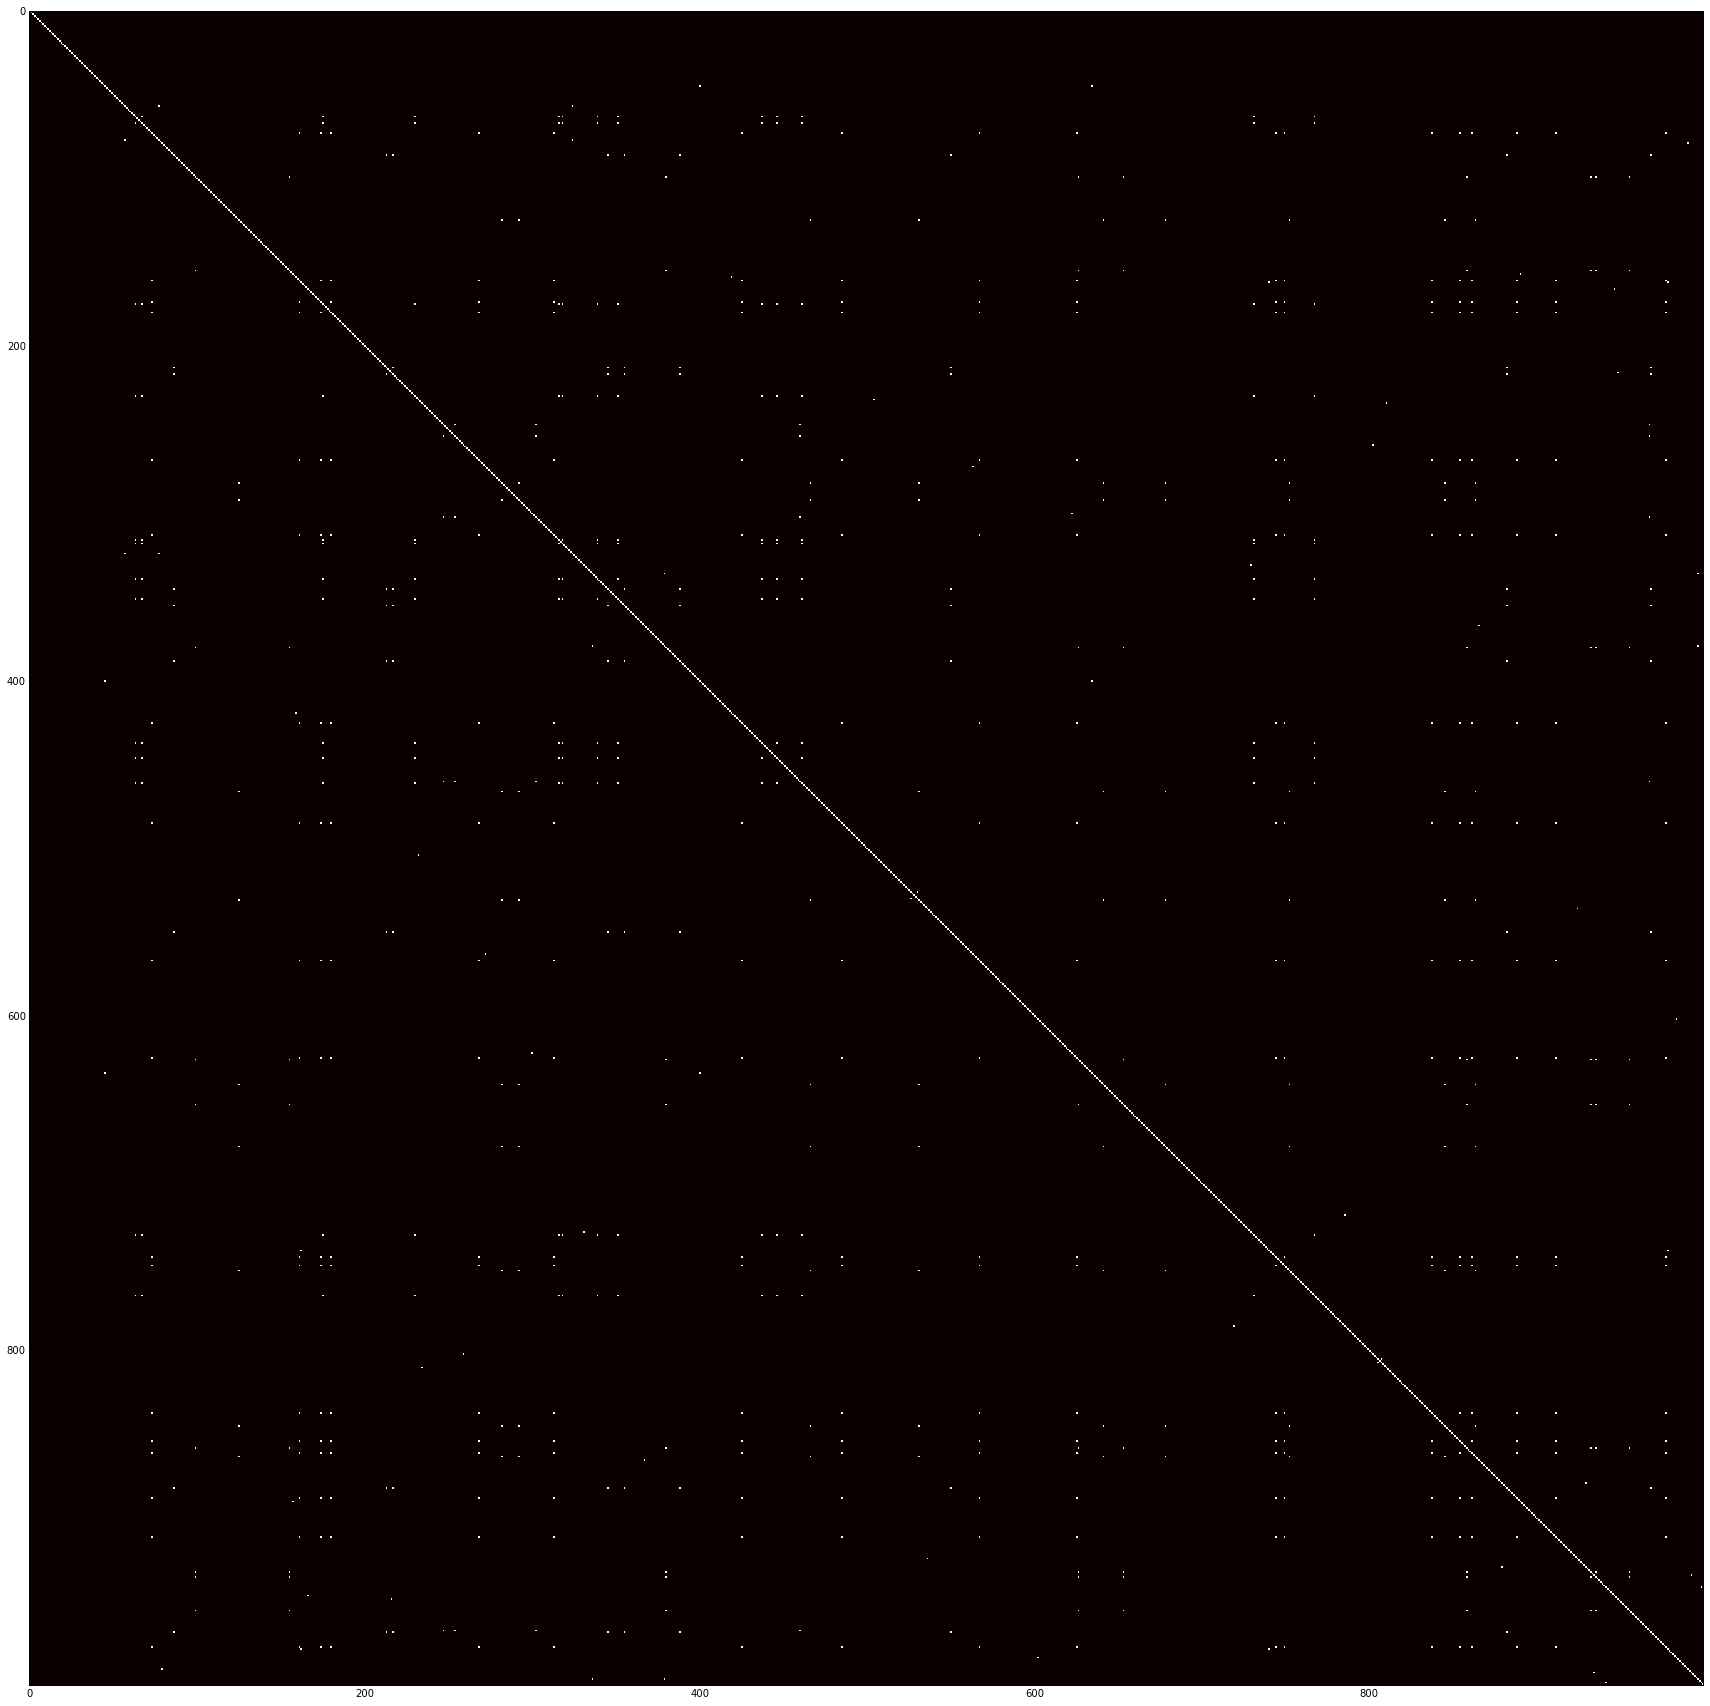

In [33]:
heatMap = Jaccard_Matrix
fig, ax = plt.subplots()
fig.set_size_inches(30, 30)
plt.imshow(heatMap[1000:2000,1000:2000], cmap='hot' , interpolation='nearest')

In [34]:
#Get all post meta data 
with open(postFile, 'rb') as f:
        lines = f.readlines()

postDict = {}
postList = []
for line in lines:
    comp = line.split(',')
    postDict[comp[0]] = comp[1]
    postList.append(comp[1])

print len(postDict) , postList[1:10]

11450 ['1233144870621925376.json\n', '1171722795202510848.json\n', '1290080547120541696.json\n', '1288686800390750208.json\n', '1137138037525221376.json\n', '1260815378305658880.json\n', '1291198489602273280.json\n', '1292323982284341248.json\n', '1267596053243674624.json\n']


In [35]:
selectedPosts = []
allPosts = []

for d in postList:
    dataRoot = "/datasets/sagarj/vineData/Dataset/Posts/" + d.strip()
    f = open(dataRoot , 'rb')
    data = json.loads(f.read())
    allPosts.append(data['data']['records'][0])

In [36]:
print len(allPosts)

11450


In [37]:
filteredPosts = dict()
for k in filteredDict:
    for post in allPosts:
        if post['postId'] == k:
            filteredPosts[k] = post
print len(filteredPosts)

3173


In [38]:
import random
rand_smpl = [ allPosts[i] for i in sorted(random.sample(xrange(len(allPosts)), len(filteredPosts))) ]
print len(rand_smpl)

allLikes = []
allReposts = []
allLoops = []
for rec in rand_smpl:
    allLikes.append(rec['likes']['count'])
    allReposts.append(rec['reposts']['count'])
    allLoops.append(rec['loops']['count'])

3173


In [39]:
print np.min(allLikes) , np.max(allLikes) , np.min(allReposts) , np.max(allReposts)

10 1006271 0 989823


In [40]:
filLikes = []
filReposts = []
filLoops = []
filPosts = []
for k in filteredPosts:
    filLikes.append(np.log(filteredPosts[k]['likes']['count']+1))
    filReposts.append(np.log(filteredPosts[k]['reposts']['count']+1))
    filLoops.append(np.log(filteredPosts[k]['loops']['count']+1))
    filPosts.append(filteredPosts[k])

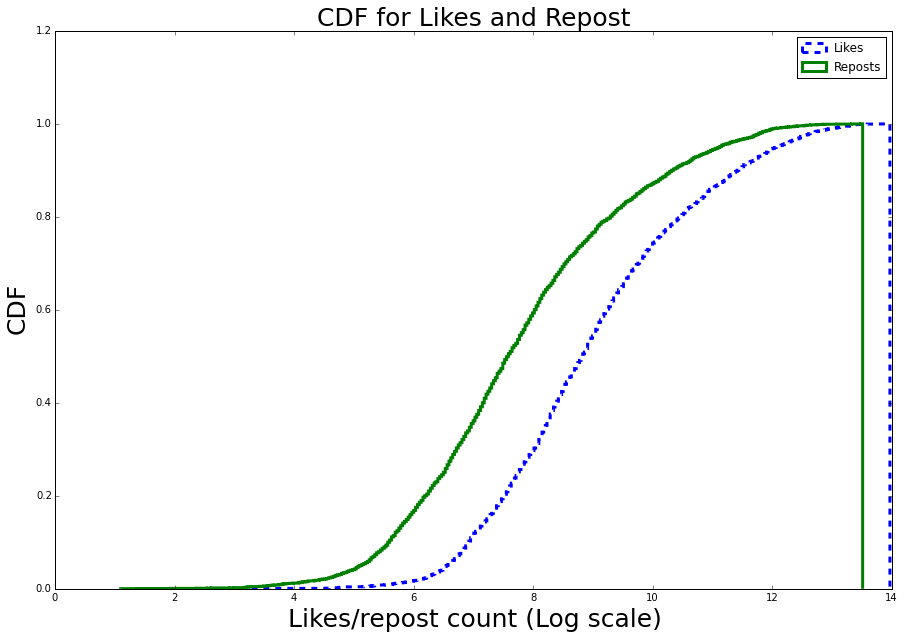

In [41]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.hist(filLikes, 400, normed=1,histtype='step', cumulative=True,linewidth = 3.0,linestyle='dashed')
plt.hist(filReposts, 400, normed=1,histtype='step', cumulative=True,linewidth = 3.0)
plt.title("CDF for Likes and Repost", fontsize = 25)
plt.xlabel("Likes/repost count (Log scale)",fontsize = 25)
plt.ylabel("CDF",fontsize = 25)
plt.legend(['Likes' , 'Reposts'])
plt.show()


In [42]:
sortedWRTLikesPosts = [x for (y,x) in sorted(zip(filLikes,filPosts))]
sortedWRTRepostsPosts = [x for (y,x) in sorted(zip(filReposts,filPosts))]

In [43]:
print np.min(filLikes) , np.max(filLikes) , np.min(filReposts) , np.max(filReposts)

3.09104245336 13.9662373831 1.09861228867 13.5099075268


In [44]:
print np.median(filLikes)
print np.median(filReposts)
print np.median(np.log(allLikes))
print np.median(np.log(allReposts))

8.83389994291
7.5903469456
8.92691588978
7.66856110802


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


In [45]:
print np.corrcoef(filReposts,filLoops)
print np.corrcoef(filLikes,filLoops)
print np.corrcoef(filReposts,filLikes)

[[ 1.         0.9081766]
 [ 0.9081766  1.       ]]
[[ 1.          0.94994312]
 [ 0.94994312  1.        ]]
[[ 1.         0.9701725]
 [ 0.9701725  1.       ]]


In [46]:
simlist = []
simcount = []
dummy_Jaccard = Jaccard_Matrix.copy()
for i in range(dummy_Jaccard.shape[0]):
    sim = []
    count = 0
    for j in range(dummy_Jaccard.shape[1]):
        if dummy_Jaccard[i][j] == 1.0:
            sim.append(j)
            dummy_Jaccard[j][i] = 0.0
            count += 1
    simlist.append(sim)
    simcount.append(count)


In [47]:
maxMatches = np.sort(simcount)[3000:3100]
matchIndexes = np.argsort(simcount)[3000:3100]

print maxMatches , matchIndexes
print np.argsort(simcount)[-5:]

[ 5  5  5  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  6  6
  6  7  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  9  9  9  9
  9  9  9  9  9  9 10 10 10 10 10 10 10 11 11 11 11 11 11 11 12 12 12 12 12
 13 13 13 13 13 14 14 14 14 14 15 15 15 15 15 16 16 16 16 16 17 17 17 17 17] [2830 2888 2889 2609 2017 2158  981  622 1941  433  810 2686 2242 2708 2591
 2175 2431  209 1431 1302 2877 1400  453 2128 2811  550 1045 2531 1810 2638
 2698 1996 2650 2396 1254  734 2384  366 2575 2236 1379 1247 2649 1234 2344
  390  166 1336 2248 1968  497 2481 2311  643 2401  137 2123 1882 2101 2275
 2272   87  155 2091 1550 1977 2258 2263   27   82 2188 1388 2028 2143 1911
 1863 1355 1888 2015 1767 1861 2002 1845 1731 1345 1461 1854 1217 1752 1955
 1837 1213 1678 1446 1935 1086 1641 1932 1437 1749]
[312 282 201 199 158]


In [48]:
# fig, ax = plt.subplots()
# fig.set_size_inches(15, 10)
# plt.plot(simcount)


In [54]:
import math
def dotproduct(v1, v2):
    return sum((a*b) for a, b in zip(v1, v2))

def length(v):
    return math.sqrt(dotproduct(v, v))

def angle(v1, v2):
    return math.acos(dotproduct(v1, v2) / (length(v1) * length(v2)))

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def topNColliniear(basis , vectors , topN):
    ang = []
    for vec in vectors:
        ang.append(angle_between(vec , basis))
    indexes = np.argsort(ang)
    print ang[indexes[0]],ang[indexes[-1]]
    print indexes[:topN]
    #returns the top N indexes with least angular value
    return indexes[:topN] , vectors[indexes[:topN]]

def getANPs(postDict , posts):
    ANP_list = []
    ids = [i['postId'] for i in posts]
    for postid in ids:
        ANP_list.append(postDict[postid])
    return ANP_list

def filterCluster(postids , posts , postDict, indexList):
    plist = []
    ANP_list = []
    ids = [postids[i] for i in indexList ]
    for postid in ids:
        plist.append(posts[postid])
        ANP_list.append(postDict[postid])
    return plist , ANP_list


In [55]:
vidnumber = matchIndexes[35]
print np.sum(dummy_Jaccard[vidnumber,:])
matched = []
for i in range(len(dummy_Jaccard[vidnumber])):
    if dummy_Jaccard[vidnumber][i]== 1.0:
        matched.append(i)
print matched

6.0
[1431, 2158, 2467, 2478, 2657, 2904]


In [58]:
# index1 , topSentis1 = topNColliniear(principals[0], senti_matrix , 3) 
matchedPosts , ANPmatched  = filterCluster(postIdFilteredList,filteredPosts,filteredDict,matched)
#print ANPmatched
import io
import base64
from IPython.display import HTML

num = 2
url = matchedPosts[num]['videoUrl'].strip().split('/')[-1].split('?')[0]
print  matchedPosts[num]['videoUrl']
#print videosBasis1[num]
print url
videoPath = "/datasets/sagarj/vineData/Dataset/Videos/" + url
#print videoPath


video = io.open(videoPath, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

http://mtc.cdn.vine.co/r/videos/3E3DAB4A081278483271957254144_13e21c4c707.3.2.mp4?versionId=C4_QpzZrSutMZ8WgtaCooX9oRGS_zOZD
3E3DAB4A081278483271957254144_13e21c4c707.3.2.mp4


In [59]:
from sklearn.svm import LinearSVR
clf = LinearSVR()

clf.fit(senti_matrix, filReposts) 
print clf.coef_

[ 0.05639029 -0.02115173 -0.06493794 -0.05885016  0.09943453 -0.02781442
  0.0465199  -0.03128881 -0.02732757  0.01962623 -0.03649007  0.07811353]


In [60]:
print senti_matrix[:100]

[[ 4.4  4.4  4.4 ...,  4.4  4.4  4.4]
 [ 2.4  2.4  2.4 ...,  2.4  2.4  2.4]
 [ 4.2  4.   1.4 ...,  4.   1.4  4. ]
 ..., 
 [ 4.4  4.4  4.4 ...,  4.4  4.4  4.4]
 [ 2.2  2.2  3.6 ...,  2.2  4.4  4.4]
 [ 2.6  2.6  2.6 ...,  3.4  2.2  2.6]]


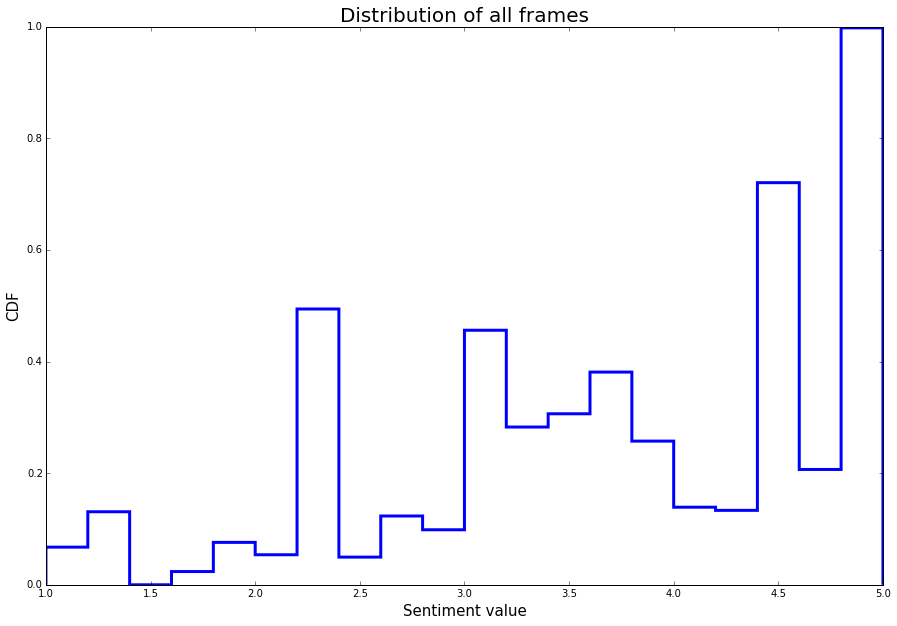

In [61]:
senti_vector = np.reshape(senti_matrix, senti_matrix.shape[0]*senti_matrix.shape[1])
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.hist(senti_vector, 20, normed=1,histtype='step', cumulative=False,linewidth = 3.0)
plt.title("Distribution of all frames", fontsize = 20)
plt.xlabel("Sentiment value",fontsize = 15)
plt.ylabel("CDF",fontsize = 15)
plt.show()

In [62]:
maxGraph = np.zeros(senti_matrix.shape[1])
minGraph = np.zeros(senti_matrix.shape[1])
varMaxGraph = np.zeros(senti_matrix.shape[1])
varMinGraph = np.zeros(senti_matrix.shape[1])
differenceList = []
id1 = []
id2 = []
for i in range(len(senti_matrix)):
    a = max(senti_matrix[i])
    b = min(senti_matrix[i])
    median_sent = np.median(senti_matrix[i])
    diff = a - b
    
    diff2 = a - median_sent
    if diff > 0.5:
        ind1 = senti_matrix[i].tolist().index(a)
        if ind1 < 2:
             id1.append(i)
        maxGraph[ind1] += 1
        ind2 = senti_matrix[i].tolist().index(b)
        if ind2 < 2:
             id2.append(i)
        minGraph[ind2] += 1
        differenceList.append(diff)
    
    
maxGraph = maxGraph/senti_matrix.shape[0]
minGraph = minGraph/senti_matrix.shape[0]
print maxGraph
print minGraph
print senti_matrix.shape
print np.sum(maxGraph),np.sum(minGraph)
print len(id1) , len(id2)

[ 0.2306965   0.091081    0.07532304  0.06177119  0.06082572  0.05294674
  0.04569808  0.04002521  0.03876458  0.04191617  0.03025528  0.02899464]
[ 0.21021116  0.09171131  0.07217145  0.06366215  0.05704381  0.04758903
  0.05074062  0.04695871  0.04412228  0.0378191   0.04380712  0.03246139]
(3173, 12)
0.798298140561 0.798298140561
1021 958


In [63]:
c3 = list(set(id1).intersection(id2))
len(c3)

219

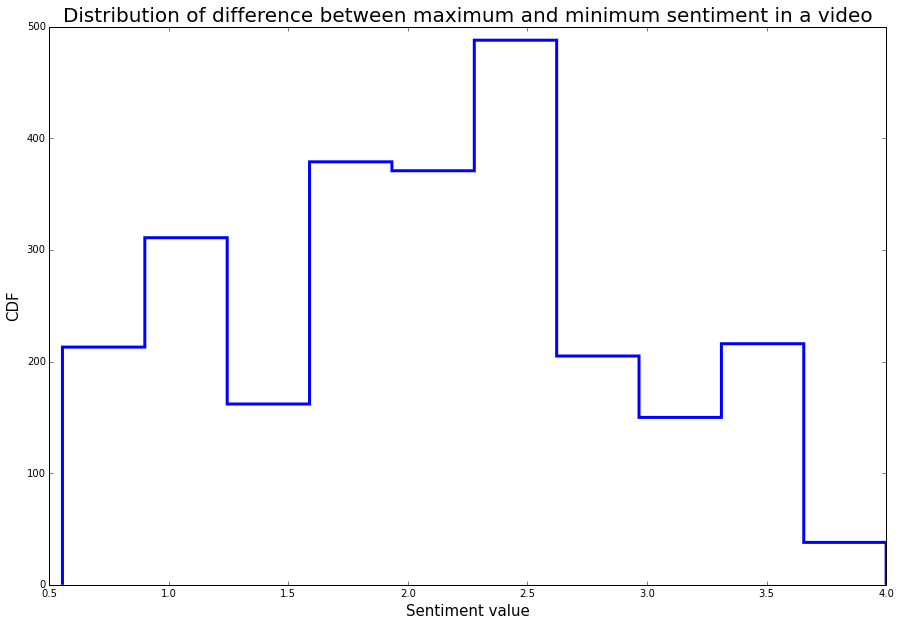

In [64]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
n, bins, patches = plt.hist(differenceList, 10, normed=0,histtype='step', cumulative=False,linewidth = 3.0)
plt.title("Distribution of difference between maximum and minimum sentiment in a video", fontsize = 20)
plt.xlabel("Sentiment value",fontsize = 15)
plt.ylabel("CDF",fontsize = 15)
plt.show()

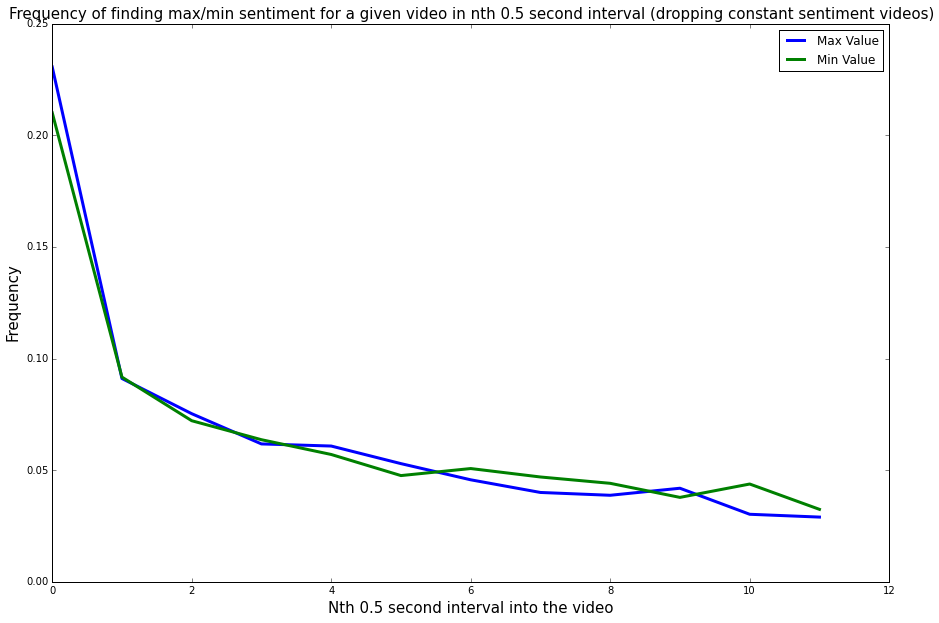

In [65]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.title("Frequency of finding max/min sentiment for a given video in nth 0.5 second interval (dropping constant sentiment videos)", fontsize = 15)
plt.xlabel("Nth 0.5 second interval into the video",fontsize = 15)
plt.ylabel("Frequency",fontsize = 15)
plt.plot(maxGraph,linewidth = 3.0)
plt.plot(minGraph,linewidth = 3.0)
plt.legend(['Max Value', 'Min Value'   
           ])
plt.show()

In [66]:
from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import minkowski

In [67]:
centroid_list = []
id_list = []
for i in range(1 , 12):
    centroids,_ = kmeans(senti_matrix,i)
    idx,_ = vq(senti_matrix,centroids)
    centroid_list.append(centroids)
    id_list.append(idx)

In [68]:
SSE_values = np.zeros(len(id_list))
for i in range(len(centroid_list)):
    for j in range(len(centroid_list[i])):
        vecs = senti_matrix[id_list[i]==j,:]
        #print vecs.shape
        cent = centroid_list[i][j]
        SSE_1 = 0.0
        for vec in vecs:
            SSE_1 = SSE_1 + minkowski(vec,cent,2)
        SSE_values[j] = SSE_values[j] + SSE_1
for i in range(len(SSE_values)):
    SSE_values[i] = SSE_values[i]/(i+1)

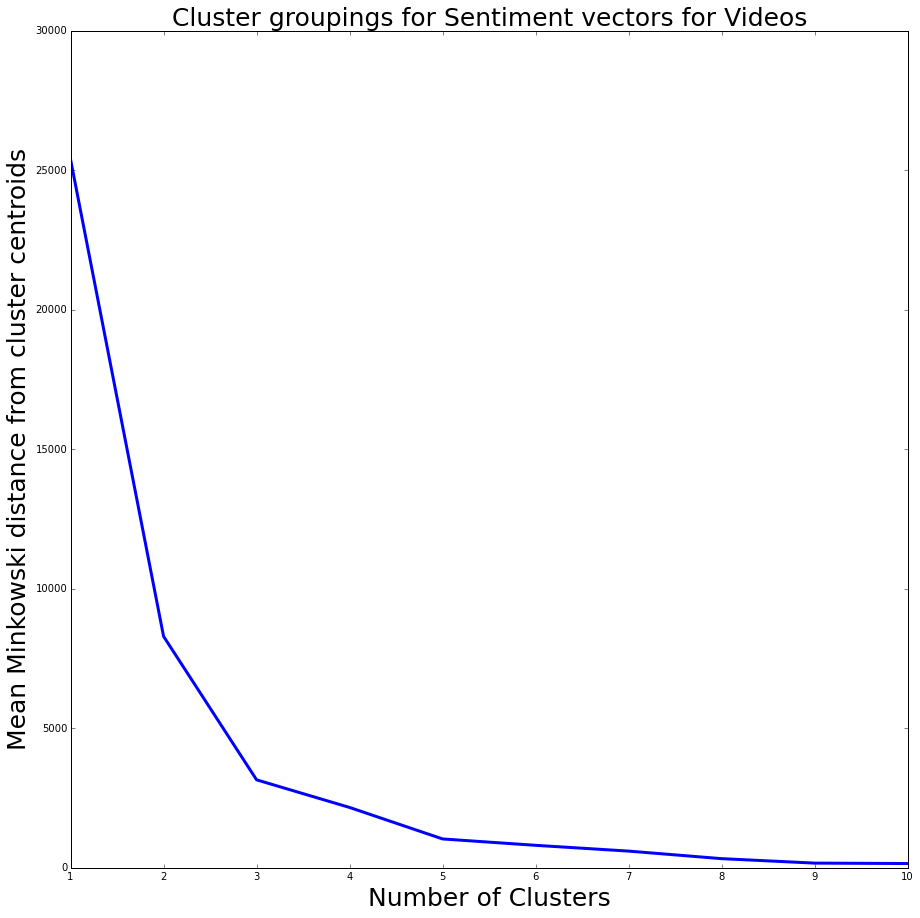

In [69]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 15)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
x = np.arange(1,11)
plt.plot(x,SSE_values[:10] ,linewidth = 3.0)
plt.xlabel("Number of Clusters", fontsize = 25)
plt.ylabel("Mean Minkowski distance from cluster centroids", fontsize = 25)
plt.title("Cluster groupings for Sentiment vectors for Videos", fontsize = 25)
plt.show()

In [70]:
print SSE_values

[ 25383.18515246   8293.62734488   3152.67867426   2162.69379471
   1034.2188583     805.6291625     598.25621493    327.98749913
    167.93522291    153.0625388      33.4979094 ]


In [71]:
U, s, V = np.linalg.svd(senti_matrix, full_matrices=False)

In [72]:
print U.shape,  np.diag(s).shape, V.shape
print s

(3173, 12) (12, 12) (12, 12)
[ 721.04352533   62.83361298   49.68192699   46.0622449    40.3171497
   39.57280596   37.50252646   35.87788377   34.34220174   33.80151533
   33.07658414   32.18794828]


In [73]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
low_dim_senti_matrix = pca.fit_transform(senti_matrix)
print low_dim_senti_matrix.shape

(3173, 5)


In [74]:
variances = pca.explained_variance_ratio_
print variances[:5]

[ 0.53070068  0.09816306  0.06101944  0.05283938  0.0404407 ]


In [75]:
principals=  2.5 + 5*pca.components_
#principals=  pca.components_
print principals[:5]

[[ 1.18523091  1.14409922  1.08022722  1.01643521  1.04098764  1.00024618
   1.00685394  0.9898205   1.02391307  1.05801885  1.03705961  1.11084437]
 [ 4.33743743  4.38115569  4.21976036  3.92267766  3.52786758  2.73169732
   2.14906886  1.66310098  1.12778201  0.81290396  0.66177005  0.75032093]
 [ 3.97707901  4.21650586  3.33627862  2.04392051  1.25171096  0.51704585
   0.33665813  1.00318589  2.06789907  3.55474403  4.11750388  4.12423108]
 [ 1.38579483  1.35139095  2.26429584  3.79261099  4.54757596  3.87703825
   1.87094317  0.55809461  0.24386011  1.90528679  3.82636837  4.30394836]
 [ 4.00846066  2.84639574  2.01360439  1.14099566  0.91404759  2.90097411
   5.00191421  3.26068299  0.36033148  0.66757967  2.83748973  4.21959279]]


In [76]:
#Trying to cluster in the SVD space 

low_dim_centroid_list = []
low_dim_id_list = []
for i in range(1 , 12):
    centroids,_ = kmeans(low_dim_senti_matrix,i)
    idx,_ = vq(low_dim_senti_matrix,centroids)
    low_dim_centroid_list.append(centroids)
    low_dim_id_list.append(idx)
    
low_dim_SSE_values = np.zeros(len(low_dim_id_list))
for i in range(len(low_dim_centroid_list)):
    for j in range(len(low_dim_centroid_list[i])):
        vecs = low_dim_senti_matrix[id_list[i]==j,:]
        #print vecs.shape
        cent = low_dim_centroid_list[i][j]
        SSE_1 = 0.0
        for vec in vecs:
            SSE_1 = SSE_1 + minkowski(vec,cent,2)
        low_dim_SSE_values[j] = low_dim_SSE_values[j] + SSE_1
for i in range(len(low_dim_SSE_values)):
    low_dim_SSE_values[i] = low_dim_SSE_values[i]/(i+1)

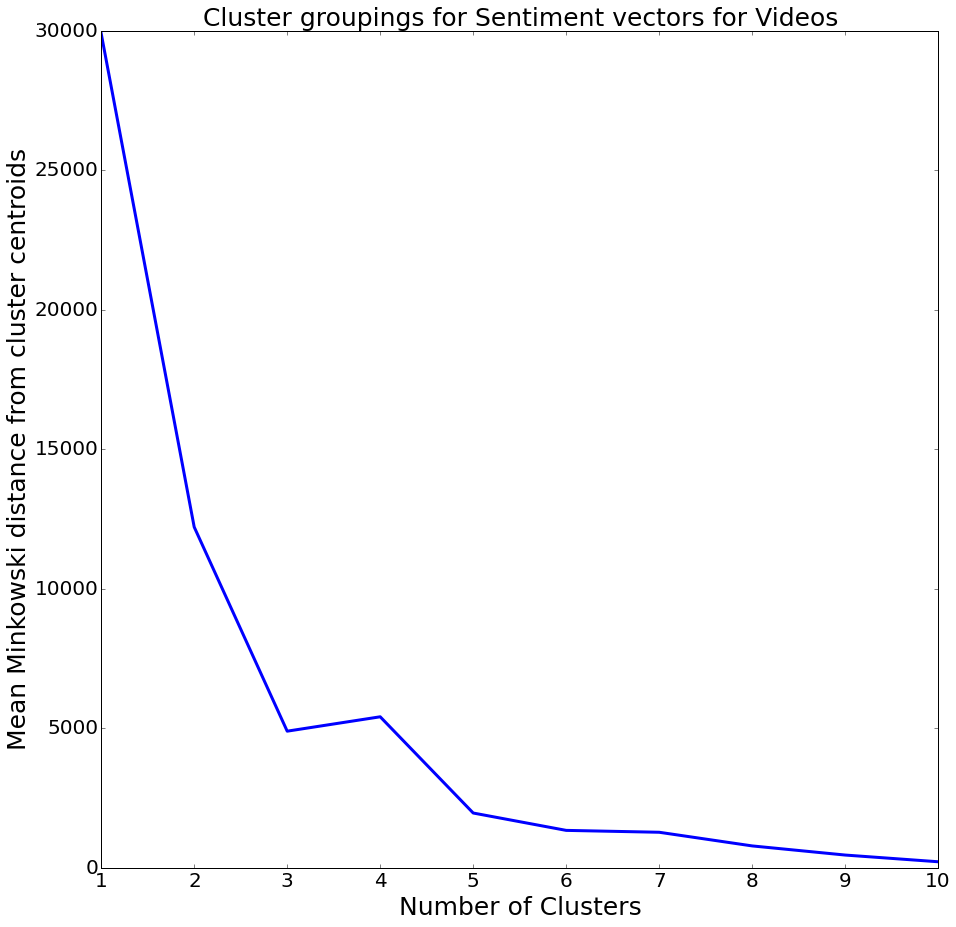

In [77]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 15)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
x = np.arange(1,11)
plt.plot(x,low_dim_SSE_values[:10] ,linewidth = 3.0)
plt.xlabel("Number of Clusters", fontsize = 25)
plt.ylabel("Mean Minkowski distance from cluster centroids", fontsize = 25)
plt.title("Cluster groupings for Sentiment vectors for Videos", fontsize = 25)
plt.show()

In [136]:
low_dim_centroid_final,_ = kmeans(low_dim_senti_matrix,3)
low_dim_idx_final,_ = vq(low_dim_senti_matrix,low_dim_centroid_final)

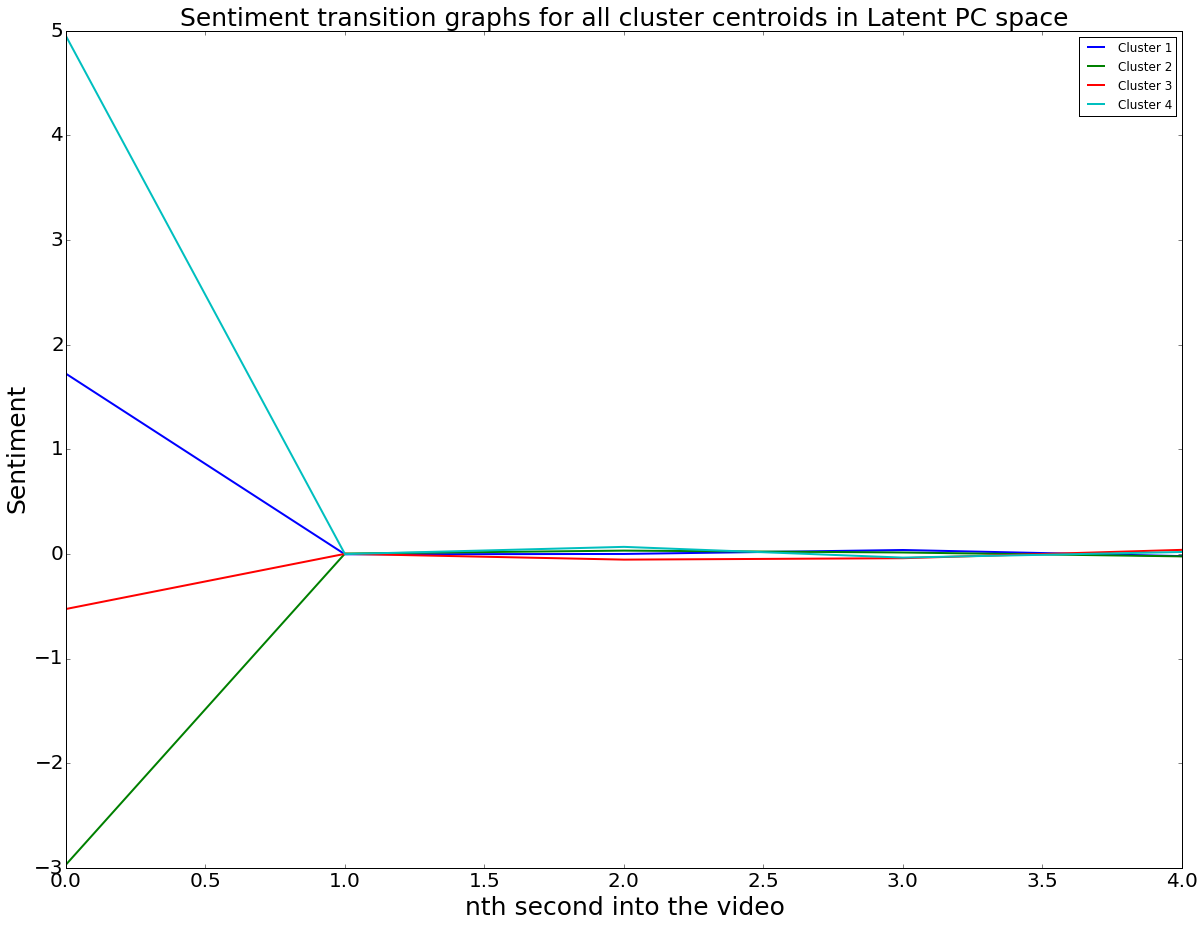

In [79]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 15)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
plt.title("Sentiment transition graphs for all cluster centroids in Latent PC space", fontsize = 25)
plt.plot(low_dim_centroid_final[0], linewidth = 2.0)
plt.plot(low_dim_centroid_final[1], linewidth = 2.0)
plt.plot(low_dim_centroid_final[2], linewidth = 2.0)
plt.plot(low_dim_centroid_final[3], linewidth = 2.0)
#plt.plot(centroid_final[4], linewidth = 2.0 )
# plt.plot(centroid_final[5], linewidth = 2.0 )
# plt.plot(centroid_final[6], linewidth = 2.0 )

plt.xlabel("nth second into the video", fontsize = 25)
plt.ylabel("Sentiment", fontsize = 25)
plt.legend(['Cluster 1', 'Cluster 2' , 'Cluster 3' 
            ,'Cluster 4'
            ,'Cluster 5'
            #,'Cluster 6'
            #,'Cluster 7'
            
           ])
plt.show()

In [80]:
# S = np.diag(s)
# Mhat = np.dot(U, np.dot(S, V.T))
# print Mhat.shape

In [81]:
# print "Using all PCs, MSE = %.6G" %(np.mean((senti_matrix - Mhat)**2)/len(senti_matrix))

In [82]:
# Mhat2 = np.dot(U[:, :1], np.dot(S[:1, :1], V[:,:1].T))
# print Mhat2.shape
# print "Using first 20 PCs, MSE = %.6G" %(np.mean((senti_matrix - Mhat2)**2)/len(senti_matrix))

In [83]:
# norms = np.linalg.norm(Modes,axis=1)

# indexlist = np.argsort(np.linalg.norm(Modes,axis=1))
# sorted_modes = Modes[indexlist]
# norms = np.linalg.norm(sorted_modes,axis=1)
# plt.plot(s)
# plt.show()

In [84]:
#print sorted_modes[:3]

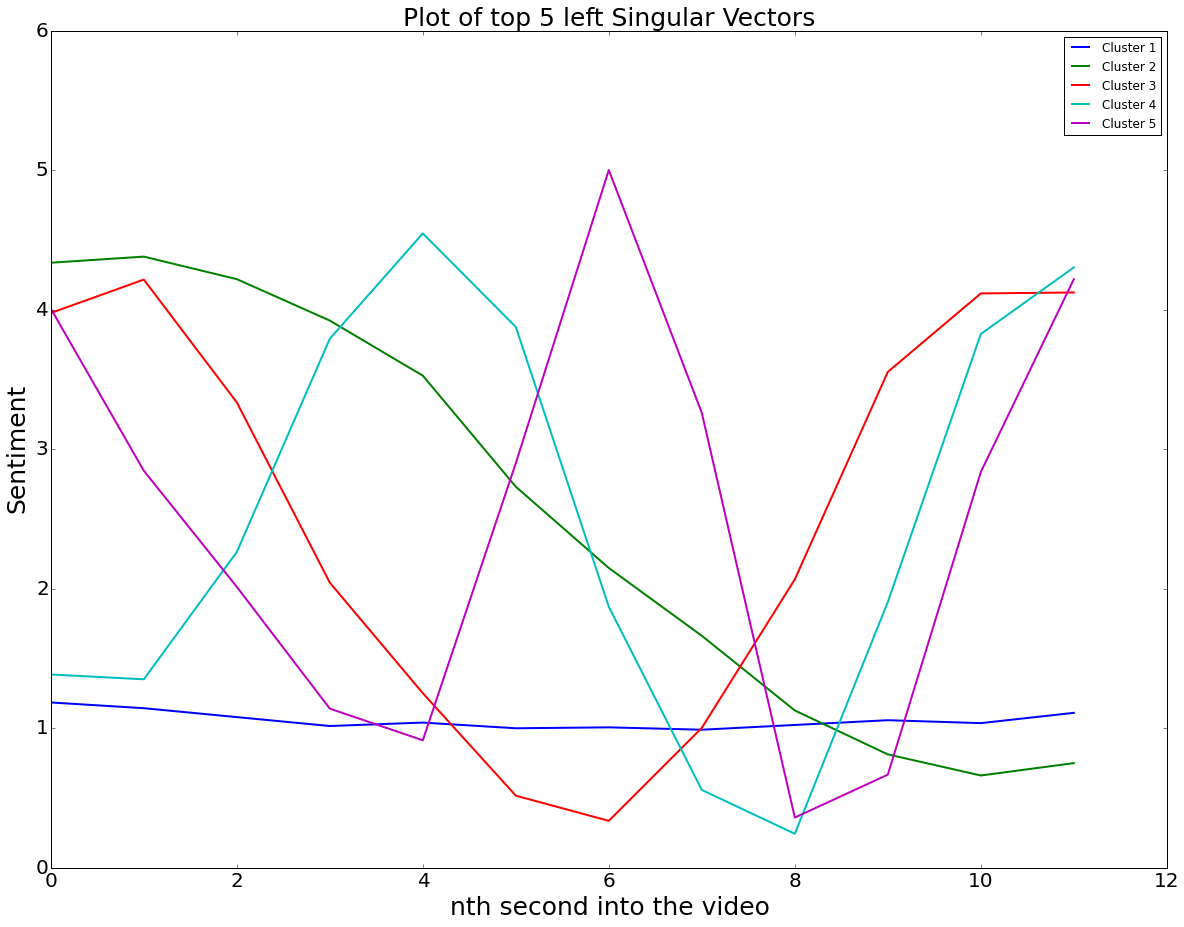

In [85]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 15)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
plt.title("Plot of top 5 left Singular Vectors", fontsize = 25)
plt.plot(principals[0], linewidth = 2.0)
plt.plot(principals[1], linewidth = 2.0)
plt.plot(principals[2], linewidth = 2.0)
plt.plot(principals[3], linewidth = 2.0)
plt.plot(principals[4], linewidth = 2.0 )
#plt.plot(principals[5], linewidth = 2.0 )
#plt.plot(principals[6], linewidth = 2.0 )
#plt.plot(sorted_modes[7,1:], linewidth = 2.0 )
#plt.plot(principals[8,1:], linewidth = 2.0 )

plt.xlabel("nth second into the video", fontsize = 25)
plt.ylabel("Sentiment", fontsize = 25)
plt.legend(['Cluster 1', 'Cluster 2' , 'Cluster 3' 
            ,'Cluster 4'
            ,'Cluster 5'
            #,'Cluster 6'
            #,'Cluster 7'
            
           ])
plt.show()

In [86]:
index1 , topSentis1 = topNColliniear(principals[0], senti_matrix , 3) 
videosBasis1 , ANP1  = filterCluster(postIdFilteredList,filteredPosts,filteredDict,index1)

index2 , topSentis2 = topNColliniear(principals[1], senti_matrix , 3) 
videosBasis2 , ANP2  = filterCluster(postIdFilteredList,filteredPosts,filteredDict,index2)

index3 , topSentis3 = topNColliniear(principals[2], senti_matrix , 3) 
videosBasis3 , ANP3  = filterCluster(postIdFilteredList,filteredPosts,filteredDict,index3)

index4 , topSentis4 = topNColliniear(principals[3], senti_matrix , 3) 
videosBasis4 , ANP4  = filterCluster(postIdFilteredList,filteredPosts,filteredDict,index4)

index5 , topSentis5 = topNColliniear(principals[4], senti_matrix , 3) 
videosBasis5 , ANP5  = filterCluster(postIdFilteredList,filteredPosts,filteredDict,index5)

0.0345271770882 0.628781312687
[2853 1095  108]
0.194924956432 0.9889919232
[1131 2098 2855]
0.248927724523 0.936479554706
[2375 1919 1297]
0.231458939779 0.956614455251
[  60  303 3108]
0.320343671012 0.932241621939
[ 975  998 1656]


In [87]:
print ANP2

[{1: 'amazing_people', 2: 'amazing_people', 3: 'great_moment', 4: 'great_moment', 5: 'amazing_people', 6: 'amazing_people', 7: 'sad_quotes', 'indexList': [51912, 51913, 51914, 51915, 51916, 51917, 51918]}, {1: 'funny_tshirts', 2: 'funny_tshirts', 3: 'silver_earrings', 4: 'funny_tshirts', 5: 'funny_tshirts', 6: 'funny_tshirts', 7: 'chronic_pain', 8: 'chronic_pain', 9: 'chronic_pain', 10: 'chronic_pain', 'indexList': [55402, 55403, 55404, 55405, 55406, 55407, 55408, 55409, 55410, 55411]}, {1: 'awesome_hair', 2: 'awesome_hair', 3: 'awesome_hair', 4: 'awesome_hair', 5: 'awesome_hair', 6: 'bad_hair', 7: 'bad_hair', 8: 'scary_face', 9: 'bad_hair', 10: 'bad_hair', 11: 'bad_hair', 12: 'bad_hair', 13: 'natural_hair', 'indexList': [45729, 45730, 45731, 45732, 45733, 45734, 45735, 45736, 45737, 45738, 45739, 45740, 45741]}]


In [88]:
selectedid =  videosBasis5[2]['postId']
print megaDict[selectedid]
videoSentimentIndices = megaDict[selectedid]['indexList']
for i in range(len(videoSentimentIndices)):
    a = vineList[videoSentimentIndices[i]].split(',')
    print "Image %d :  %s" %(i , str(a))

{1: 'light_square', 2: 'impossible_project', 3: 'impossible_project', 4: 'impossible_project', 5: 'impossible_project', 6: 'impossible_project', 7: 'special_offers', 8: 'magic_tricks', 9: 'impossible_project', 10: 'impossible_project', 11: 'impossible_project', 12: 'low_price', 'indexList': [106192, 106193, 106194, 106195, 106196, 106197, 106198, 106199, 106200, 106201, 106202, 106203]}
Image 0 :  ['/datasets/sagarj/vineData/Dataset/fineSamples/1290793644055773184_10.jpg', 'impossible_project', '0.031638', 'sad_quotes', '0.0211724', 'real_talk', '0.0116822', 'broken_hearts', '0.00841733', 'positive_vibes', '0.00691178']
Image 1 :  ['/datasets/sagarj/vineData/Dataset/fineSamples/1290793644055773184_11.jpg', 'impossible_project', '0.0373405', 'great_moment', '0.0102124', 'real_talk', '0.00729759', 'positive_vibes', '0.00662022', 'sad_quotes', '0.00578364']
Image 2 :  ['/datasets/sagarj/vineData/Dataset/fineSamples/1290793644055773184_12.jpg', 'low_price', '0.026105', 'unique_pillow', '0.

In [89]:
# for k in ANP1:
#     indexes = k['indexList']
#     for i in indexes:
#         print vineList[i]

In [90]:
print (180/3.142)*0.034

1.94780394653


In [91]:
import io
import base64
from IPython.display import HTML

num = 2
url = videosBasis5[num]['videoUrl'].strip().split('/')[-1].split('?')[0]
print  videosBasis5[num]['videoUrl']
#print videosBasis1[num]
#print url
videoPath = "/datasets/sagarj/vineData/Dataset/Videos/" + url
#print videoPath


video = io.open(videoPath, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

http://mtc.cdn.vine.co/r/videos/AF289DC6A81290793640612225024_1afbbc531cf.3.2.mp4?versionId=0SrZxHCIA.UgAnLvCKGLJA.QZFM8mdeD


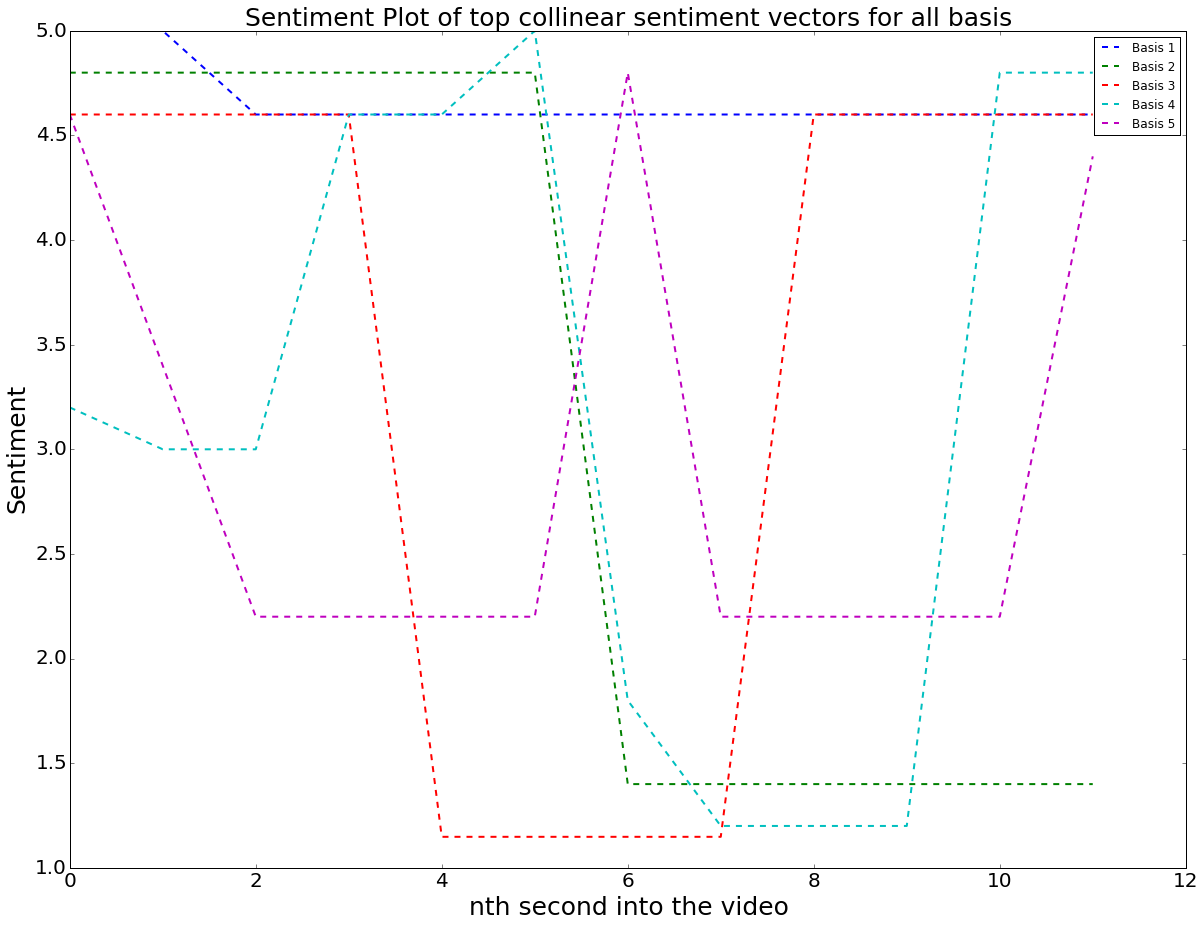

In [92]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 15)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
plt.title("Sentiment Plot of top collinear sentiment vectors for all basis", fontsize = 25)
plt.plot(topSentis1[0], linewidth = 2.0 , linestyle='dashed')
plt.plot(topSentis2[0], linewidth = 2.0 , linestyle='dashed')
plt.plot(topSentis3[0], linewidth = 2.0 , linestyle='dashed')
plt.plot(topSentis4[0], linewidth = 2.0 , linestyle='dashed')
plt.plot(topSentis5[0], linewidth = 2.0 , linestyle='dashed')

plt.xlabel("nth second into the video", fontsize = 25)
plt.ylabel("Sentiment", fontsize = 25)
plt.legend(['Basis 1', 'Basis 2' , 'Basis 3' 
            ,'Basis 4'
            ,'Basis 5'
            #,'Cluster 6'
            #,'Cluster 7'
            
           ])
plt.show()

In [93]:
centroid_final,_ = kmeans(senti_matrix,4)
idx_final,_ = vq(senti_matrix,centroid_final)

In [94]:
vecs1 = senti_matrix[idx_final==0,:]
vecs2 = senti_matrix[idx_final==1,:]
vecs3 = senti_matrix[idx_final==2,:]
vecs4 = senti_matrix[idx_final==3,:]
# vecs5 = senti_matrix[idx_final==4,:]
# vecs6 = senti_matrix[idx_final==5,:]
# vecs7 = senti_matrix[idx_final==6,:]
#senti_matrix[idx_final==0]

In [95]:
print len(vecs1)
print len(vecs2)
print len(vecs3)
print len(vecs4)
# print len(vecs5)
# print len(vecs6)
# print len(vecs7)

938
976
939
320


In [96]:
print centroid_final

[[ 4.44321848  4.44016101  4.46717288  4.51213316  4.51073743  4.49988765
   4.46498757  4.48668079  4.4929689   4.47453716  4.46837839  4.44115635]
 [ 3.17716346  3.16372951  3.1249468   3.12572124  3.15998778  3.11300835
   3.08063131  3.07111444  3.08248354  3.12838518  3.0820205   3.13088934]
 [ 3.76953592  3.77588624  3.79247563  3.76136233  3.74684598  3.8028591
   3.83927815  3.76772112  3.76878599  3.75444417  3.70843778  3.73357072]
 [ 2.38935096  2.30138822  2.25078752  2.12763822  2.13527644  2.11513822
   2.11388822  2.06983801  2.18622596  2.17826322  2.15935096  2.25747596]]


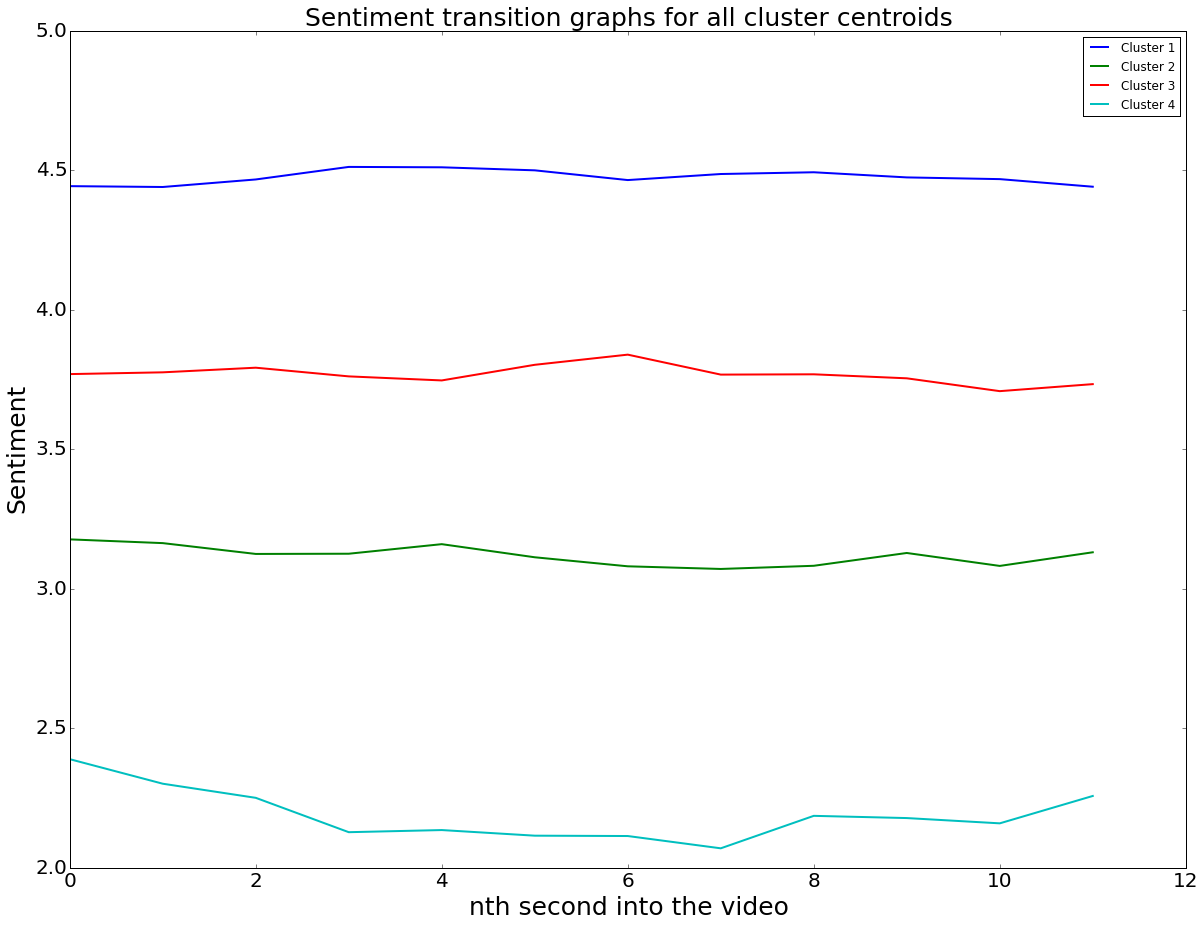

In [97]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 15)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
plt.title("Sentiment transition graphs for all cluster centroids", fontsize = 25)
plt.plot(centroid_final[0], linewidth = 2.0)
plt.plot(centroid_final[1], linewidth = 2.0)
plt.plot(centroid_final[2], linewidth = 2.0)
plt.plot(centroid_final[3], linewidth = 2.0)
#plt.plot(centroid_final[4], linewidth = 2.0 )
# plt.plot(centroid_final[5], linewidth = 2.0 )
# plt.plot(centroid_final[6], linewidth = 2.0 )

plt.xlabel("nth second into the video", fontsize = 25)
plt.ylabel("Sentiment", fontsize = 25)
plt.legend(['Cluster 1', 'Cluster 2' , 'Cluster 3' 
            ,'Cluster 4'
            ,'Cluster 5'
            #,'Cluster 6'
            #,'Cluster 7'
            
           ])
plt.show()

In [98]:
index1_clusters , topSentis1_clusters = topNColliniear(centroid_final[0], senti_matrix[idx_final==0,:] , 100) 
videosBasis1_clusters , ANP1_clusters  = filterCluster(postIdFilteredList,filteredPosts,filteredDict,index1_clusters)

index2_clusters , topSentis2_clusters = topNColliniear(centroid_final[1], senti_matrix[idx_final==1,:] , 100) 
videosBasis2_clusters , ANP2_clusters  = filterCluster(postIdFilteredList,filteredPosts,filteredDict,index2_clusters)

index3_clusters , topSentis3_clusters = topNColliniear(centroid_final[2], senti_matrix[idx_final==2,:] , 100) 
videosBasis3_clusters , ANP3_clusters  = filterCluster(postIdFilteredList,filteredPosts,filteredDict,index3_clusters)

index4_clusters , topSentis4_clusters = topNColliniear(centroid_final[3], senti_matrix[idx_final==3,:] , 100) 
videosBasis4_clusters , ANP4_clusters  = filterCluster(postIdFilteredList,filteredPosts,filteredDict,index4_clusters)

# index5_clusters , topSentis5_clusters = topNColliniear(centroid_final[4], senti_matrix , 5) 
# videosBasis5_clusters , ANP5_clusters  = filterCluster(postIdFilteredList,filteredPosts,filteredDict,index5_clusters)

0.00551480887019 0.293945979409
[468 218 222 225 663 227 228 229 662 658 656 653 651 239 648 243 244 640
 638 249 635 629 623 256 620 618 612 608 598 597 671 433 213 211 137 139
 758 756 145 750 153 747 738 734 733 732 168 728 587 171 182 184 186 188
 707 705 700 195 196 692 202 688 206 682 720 135 283 295 373 375 491 381
 483 479 388 390 391 394 399 470 467 403 466 465 464 409 463 456 413 455
 446 418 422 442 438 426 429 510 365 515]
0.0108936611454 0.535248470384
[904 800 449 233 209 921 565 467 148  45 196 381 473 139 966 141 475 109
 693 945 760 279 296 542 676 337 132 197 910 602 190 416 420 500 731 798
 797 975 786 737 162 155 456 572  88 869 752 931 543 129 121 590 568 521
 709 253 352  25 708 406 711 232 374 263 840 649 382 383 256   1 943 702
 816 624 305 715 722 401 872 389 445  67 347  84 386 242 152 262 545  59
 448  66 274 446 882  20 907 240 142 877]
0.0085183368253 0.468161782503
[469 215  36 642 639 623 232 612 600 590 579 572 494 470 438 423 422 413
 408  64 366  66 36

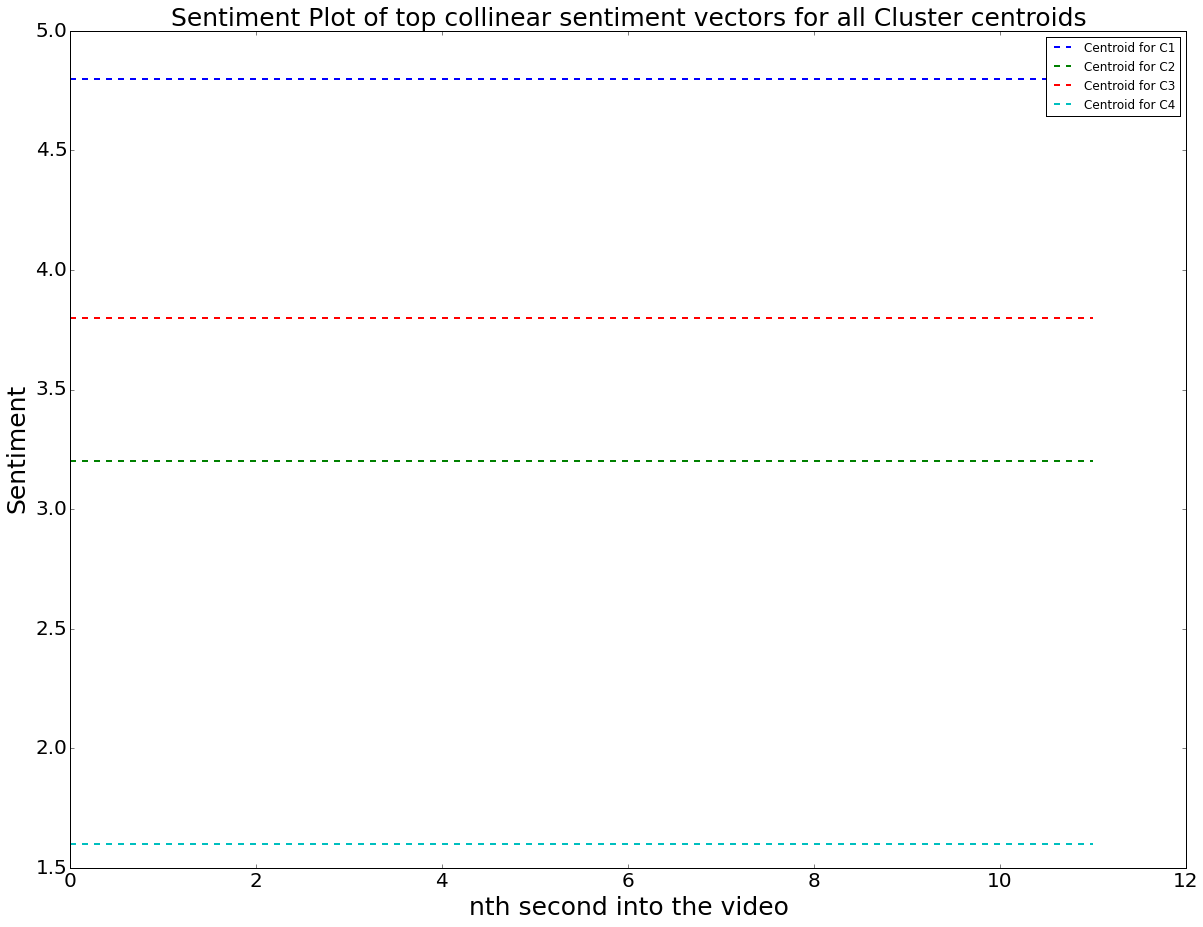

In [99]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 15)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
plt.title("Sentiment Plot of top collinear sentiment vectors for all Cluster centroids", fontsize = 25)
plt.plot(topSentis1_clusters[50], linewidth = 2.0 , linestyle='dashed')
plt.plot(topSentis2_clusters[50], linewidth = 2.0 , linestyle='dashed')
plt.plot(topSentis3_clusters[50], linewidth = 2.0 , linestyle='dashed')
plt.plot(topSentis4_clusters[50], linewidth = 2.0 , linestyle='dashed')
#plt.plot(topSentis5_clusters[4], linewidth = 2.0 , linestyle='dashed')

plt.xlabel("nth second into the video", fontsize = 25)
plt.ylabel("Sentiment", fontsize = 25)
plt.legend(['Centroid for C1', 'Centroid for C2' , 'Centroid for C3' 
            ,'Centroid for C4'
            ,'Centroid for C5'
            #,'Cluster 6'
            #,'Cluster 7'
            
           ])
plt.show()

In [100]:
selectedid =  videosBasis4_clusters[2]['postId']
print megaDict[selectedid]
videoSentimentIndices = megaDict[selectedid]['indexList']
for i in range(len(videoSentimentIndices)):
    a = vineList[videoSentimentIndices[i]].split(',')
    print "Image %d :  %s" %(i , str(a))

{1: 'impossible_project', 2: 'impossible_project', 3: 'great_moment', 4: 'great_moment', 5: 'sparkling_heart', 6: 'impossible_project', 7: 'impossible_project', 8: 'broken_hearts', 9: 'impossible_project', 10: 'impossible_project', 11: 'impossible_project', 12: 'impossible_project', 'indexList': [53000, 53001, 53002, 53003, 53004, 53005, 53006, 53007, 53008, 53009, 53010, 53011]}
Image 0 :  ['/datasets/sagarj/vineData/Dataset/fineSamples/1281035834342117376_10.jpg', 'impossible_project', '0.0221853', 'sad_quotes', '0.0106705', 'positive_vibes', '0.00681878', 'real_talk', '0.00645475', 'great_moment', '0.00626531']
Image 1 :  ['/datasets/sagarj/vineData/Dataset/fineSamples/1281035834342117376_11.jpg', 'impossible_project', '0.0353535', 'soft_tone', '0.0151836', 'sad_quotes', '0.0145387', 'creative_team', '0.0066182', 'great_moment', '0.00658047']
Image 2 :  ['/datasets/sagarj/vineData/Dataset/fineSamples/1281035834342117376_12.jpg', 'impossible_project', '0.0159696', 'lovely_ladies', '0

In [101]:
import io
import base64
from IPython.display import HTML

num = 2
url = videosBasis4_clusters[num]['videoUrl'].strip().split('/')[-1].split('?')[0]
print  videosBasis4_clusters[num]['videoUrl']
print  videosBasis4_clusters[num]['postId']
#print videosBasis1[num]
#print url
videoPath = "/datasets/sagarj/vineData/Dataset/Videos/" + url
#print videoPath


video = io.open(videoPath, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

http://mtc.cdn.vine.co/r/videos/04FB188C901281035820719570944_1b64435e6d7.3.2.mp4?versionId=_QNXqZbVIhy0XH9lWqW2oGjs4MsMacsq
1281035834342117376


In [102]:
index1_clusters , topSentis1_clusters = topNColliniear(centroid_final[0], senti_matrix[idx_final==0,:] , 100) 
videos1_clusters , ANP1_clusters  = filterCluster(postIdFilteredList,filteredPosts,filteredDict,index1_clusters)

index2_clusters , topSentis2_clusters = topNColliniear(centroid_final[1], senti_matrix[idx_final==1,:] , 100) 
videos2_clusters , ANP2_clusters  = filterCluster(postIdFilteredList,filteredPosts,filteredDict,index2_clusters)

index3_clusters , topSentis3_clusters = topNColliniear(centroid_final[2], senti_matrix[idx_final==2,:] , 100) 
videos3_clusters , ANP3_clusters  = filterCluster(postIdFilteredList,filteredPosts,filteredDict,index3_clusters)

index4_clusters , topSentis4_clusters = topNColliniear(centroid_final[3], senti_matrix[idx_final==3,:] , 100) 
videos4_clusters , ANP4_clusters  = filterCluster(postIdFilteredList,filteredPosts,filteredDict,index4_clusters)

0.00551480887019 0.293945979409
[468 218 222 225 663 227 228 229 662 658 656 653 651 239 648 243 244 640
 638 249 635 629 623 256 620 618 612 608 598 597 671 433 213 211 137 139
 758 756 145 750 153 747 738 734 733 732 168 728 587 171 182 184 186 188
 707 705 700 195 196 692 202 688 206 682 720 135 283 295 373 375 491 381
 483 479 388 390 391 394 399 470 467 403 466 465 464 409 463 456 413 455
 446 418 422 442 438 426 429 510 365 515]
0.0108936611454 0.535248470384
[904 800 449 233 209 921 565 467 148  45 196 381 473 139 966 141 475 109
 693 945 760 279 296 542 676 337 132 197 910 602 190 416 420 500 731 798
 797 975 786 737 162 155 456 572  88 869 752 931 543 129 121 590 568 521
 709 253 352  25 708 406 711 232 374 263 840 649 382 383 256   1 943 702
 816 624 305 715 722 401 872 389 445  67 347  84 386 242 152 262 545  59
 448  66 274 446 882  20 907 240 142 877]
0.0085183368253 0.468161782503
[469 215  36 642 639 623 232 612 600 590 579 572 494 470 438 423 422 413
 408  64 366  66 36

In [103]:
selectedid =  videos1_clusters[2]['postId']
print megaDict[selectedid]
videoSentimentIndices = megaDict[selectedid]['indexList']
for i in range(len(videoSentimentIndices)):
    a = vineList[videoSentimentIndices[i]].split(',')
    print "Image %d :  %s" %(i , str(a))

{1: 'primary_education', 2: 'primary_education', 3: 'technical_illustration', 4: 'primary_education', 5: 'primary_education', 6: 'primary_education', 7: 'primary_education', 8: 'technical_illustration', 9: 'technical_illustration', 10: 'primary_education', 11: 'technical_illustration', 12: 'technical_illustration', 'indexList': [110526, 110527, 110528, 110529, 110530, 110531, 110532, 110533, 110534, 110535, 110536, 110537]}
Image 0 :  ['/datasets/sagarj/vineData/Dataset/fineSamples/1291186066967142400_10.jpg', 'primary_education', '0.0375144', 'technical_illustration', '0.0319527', 'visual_diary', '0.0203844', 'automatic_drawing', '0.0126048', 'medical_illustration', '0.0112876']
Image 1 :  ['/datasets/sagarj/vineData/Dataset/fineSamples/1291186066967142400_11.jpg', 'technical_illustration', '0.0310088', 'automatic_drawing', '0.0272757', 'visual_diary', '0.0266795', 'primary_education', '0.0226798', 'medical_illustration', '0.0162276']
Image 2 :  ['/datasets/sagarj/vineData/Dataset/fin

In [104]:
def filterCluster(postids , posts , postDict, clusterMems , clusterId ):
    plist = []
    ANP_list = []
    selective = clusterMems == clusterId
    ids = [i for (i, v) in zip(postids, selective) if v]
    for postid in ids:
        plist.append(posts[postid])
        ANP_list.append(postDict[postid])
    return plist , ANP_list

def likesRepostsLoops(cluster):
    likes = np.zeros(len(cluster))
    reposts = np.zeros(len(cluster))
    loops = np.zeros(len(cluster))
    for i in range(len(cluster)):
        likes[i] = np.log(cluster[i]['likes']['count']+1)
        reposts[i] = np.log(cluster[i]['reposts']['count']+1)
        loops[i] = np.log(cluster[i]['loops']['count']+1)
    return likes, reposts, loops


In [105]:
cluster1 , ANP_cluster1 = filterCluster(postIdFilteredList,filteredPosts,filteredDict,idx_final,0)
print len(cluster1)
cluster2 , ANP_cluster2 = filterCluster(postIdFilteredList,filteredPosts,filteredDict,idx_final,1)
print len(cluster2)
cluster3 , ANP_cluster3 = filterCluster(postIdFilteredList,filteredPosts,filteredDict,idx_final,2)
print len(cluster3)
cluster4 , ANP_cluster4 = filterCluster(postIdFilteredList,filteredPosts,filteredDict,idx_final,3)
print len(cluster4)
cluster5 , ANP_cluster5 = filterCluster(postIdFilteredList,filteredPosts,filteredDict,idx_final,4)
print len(cluster5)

938
976
939
320
0


In [106]:
likesC1 , repostsC1 , loopsC1 = likesRepostsLoops(cluster1)
likesC2 , repostsC2 , loopsC2 = likesRepostsLoops(cluster2)
likesC3 , repostsC3 , loopsC3 = likesRepostsLoops(cluster3)
likesC4 , repostsC4 , loopsC4 = likesRepostsLoops(cluster4)
likesC5 , repostsC5 , loopsC5 = likesRepostsLoops(cluster5)

In [107]:
# likesC1 = likesC1/len(senti_matrix)
# likesC2 = likesC2/len(senti_matrix)
# likesC3 = likesC3/len(senti_matrix)
# likesC4 = likesC4/len(senti_matrix)
# likesC5 = likesC1/len(senti_matrix)


In [108]:
c1 = np.random.choice(len(likesC1), 300)
sampledLikesC1 = likesC1[c1]

c2 = np.random.choice(len(likesC2), 300)
sampledLikesC2 = likesC2[c2]

c3 = np.random.choice(len(likesC3), 300)
sampledLikesC3 = likesC3[c3]

c4 = np.random.choice(len(likesC4), 300)
sampledLikesC4 = likesC4[c4]

# c5 = np.random.choice(len(likesC5), 300)
# sampledLikesC5 = likesC5[c5]


In [109]:
print "Numbers for Cluster C1: Median Reposts: %f , Mean Reposts: %f , Median Likes: %f , \
Mean Likes: %f , Median Loops: %f , Mean Loops \
%f"%(np.median(repostsC1),np.mean(repostsC1),np.median(sampledLikesC1),np.mean(sampledLikesC1),np.median(loopsC1),np.mean(loopsC1))

print "Numbers for Cluster C2: Median Reposts: %f , Mean Reposts: %f , Median Likes: %f , \
Mean Likes: %f , Median Loops: %f , Mean Loops \
%f"%(np.median(repostsC2),np.mean(repostsC2),np.median(sampledLikesC2),np.mean(sampledLikesC2),np.median(loopsC2),np.mean(loopsC2))

print "Numbers for Cluster C3: Median Reposts: %f , Mean Reposts: %f , Median Likes: %f , \
Mean Likes: %f , Median Loops: %f , Mean Loops \
%f"%(np.median(repostsC3),np.mean(repostsC3),np.median(sampledLikesC3),np.mean(sampledLikesC3),np.median(loopsC3),np.mean(loopsC3))

print "Numbers for Cluster C4: Median Reposts: %f , Mean Reposts: %f , Median Likes: %f , \
Mean Likes: %f , Median Loops: %f , Mean Loops \
%f"%(np.median(repostsC4),np.mean(repostsC4),np.median(sampledLikesC4),np.mean(sampledLikesC4),np.median(loopsC4),np.mean(loopsC4))

# print "Numbers for Cluster C5: Median Reposts: %f , Mean Reposts: %f , Median Likes: %f , \
# Mean Likes: %f , Median Loops: %f , Mean Loops \
# %f"%(np.median(repostsC5),np.mean(repostsC5),np.median(sampledLikesC5),np.mean(sampledLikesC5),np.median(loopsC5),np.mean(loopsC5))

Numbers for Cluster C1: Median Reposts: 7.553800 , Mean Reposts: 7.647810 , Median Likes: 8.906506 , Mean Likes: 8.943529 , Median Loops: 12.437089 , Mean Loops 12.458038
Numbers for Cluster C2: Median Reposts: 7.617513 , Mean Reposts: 7.834243 , Median Likes: 8.930834 , Mean Likes: 9.116704 , Median Loops: 12.558019 , Mean Loops 12.831800
Numbers for Cluster C3: Median Reposts: 7.695303 , Mean Reposts: 7.870088 , Median Likes: 8.949334 , Mean Likes: 9.146544 , Median Loops: 12.564677 , Mean Loops 12.823818
Numbers for Cluster C4: Median Reposts: 7.425344 , Mean Reposts: 7.635301 , Median Likes: 8.716466 , Mean Likes: 8.855808 , Median Loops: 12.113116 , Mean Loops 12.419072


In [110]:
clf = LinearSVR()

clf.fit(vecs3, repostsC3) 
print clf.coef_

[ 0.11990291  0.04576353  0.23605202  0.15998301 -0.06024558  0.01968531
 -0.02369047  0.10911801  0.04548113  0.14619872  0.10552952 -0.11816065]


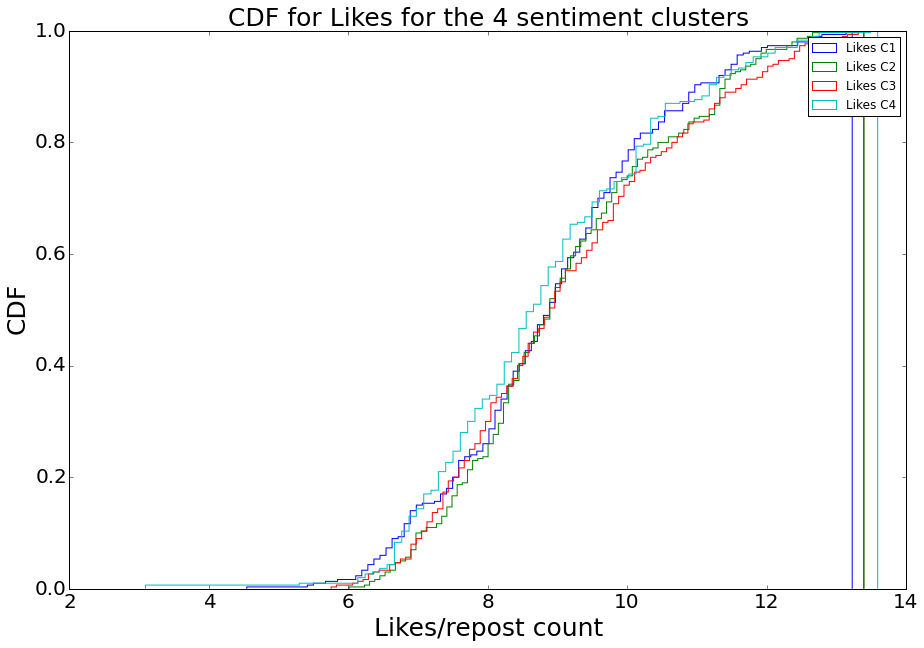

In [111]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.hist(sampledLikesC1, 100, normed=1,histtype='step', cumulative=True,linewidth = 1.0)
plt.hist(sampledLikesC2, 100, normed=1,histtype='step', cumulative=True,linewidth = 1.0)
plt.hist(sampledLikesC3, 100, normed=1,histtype='step', cumulative=True, linewidth = 1.0)
plt.hist(sampledLikesC4, 100, normed=1,histtype='step', cumulative=True, linewidth = 1.0)
# plt.hist(sampledLikesC5, 100, normed=1,histtype='step', cumulative=True, linewidth = 1.0)
plt.title("CDF for Likes for the 4 sentiment clusters ", fontsize = 25)
plt.xlabel("Likes/repost count",fontsize = 25)
plt.ylabel("CDF",fontsize = 25)
plt.legend(['Likes C1', 'Likes C2' , 'Likes C3' , 'Likes C4' , 'Likes C5'])
plt.show()

In [112]:

def plotDist(RV, samples, b):
    N = samples 
    n = b
    s = np.random.normal(size=N)   # generate your data sample with N elements
    p1, x1 = np.histogram(RV, bins=n) # bin it into n = N/10 bins
    xs1 = x1[:-1] + (x1[1] - x1[0])/2
    f1 = UnivariateSpline(xs1, p1)
    plt.plot(xs1 , f1(xs1) ,'-')

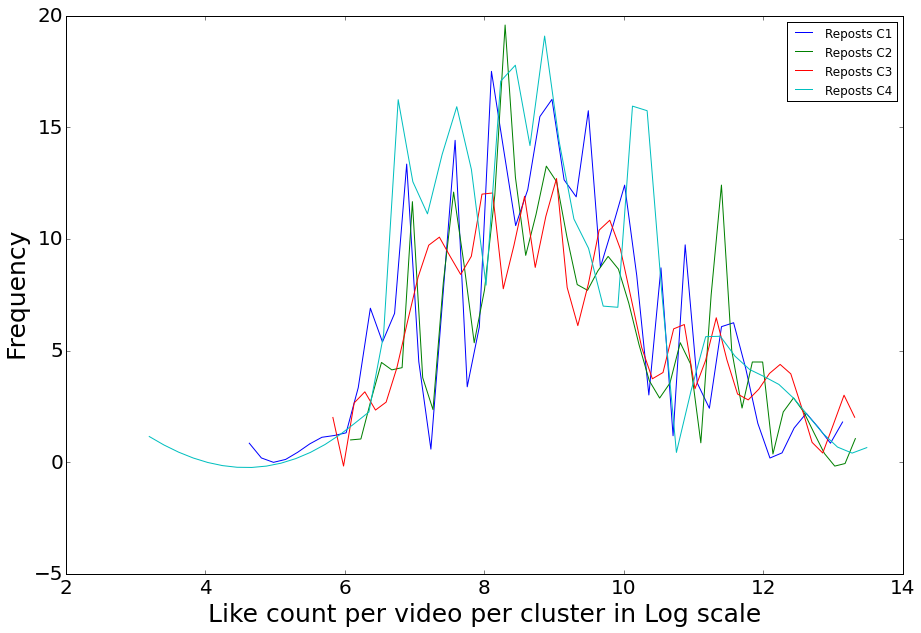

In [113]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plotDist(sampledLikesC1 , 200 , 50)
plotDist(sampledLikesC2 , 200 , 50)
plotDist(sampledLikesC3 , 200 , 50)
plotDist(sampledLikesC4 , 200 , 50)
# plotDist(sampledLikesC5 , 200 , 50)
plt.legend(['Reposts C1', 'Reposts C2' , 'Reposts C3' , 'Reposts C4', 'Reposts C4'])
plt.xlabel("Like count per video per cluster in Log scale",fontsize = 25)
plt.ylabel("Frequency ",fontsize = 25)
plt.show()

In [121]:
import io
import base64
from IPython.display import HTML

num = 155
url = cluster4[num]['videoDashUrl'].strip().split('/')[-1].split('?')[0]
print  cluster4[num]['videoDashUrl']
print ANP_cluster4[num]

#print url
videoPath = "/datasets/sagarj/vineData/Dataset/Videos/" + url
print videoPath


video = io.open(videoPath, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

http://v.cdn.vine.co/r/videos_h264dash/3C6A6CB3241237556976494993408_30b66661c49.4.3.8276679950090945220.mp4?versionId=qsMmpu9shJfudrIEVy2WgRYJWcLBzNqc
{1: 'sensitive_skin', 2: 'sensitive_skin', 3: 'sensitive_skin', 4: 'sensitive_skin', 5: 'plastic_cup', 6: 'sensitive_skin', 7: 'sensitive_skin', 8: 'sensitive_skin', 9: 'sensitive_skin', 10: 'sensitive_skin', 11: 'sensitive_skin', 12: 'sensitive_skin', 'indexList': [15227, 15228, 15229, 15230, 15231, 15232, 15233, 15234, 15235, 15236, 15237, 15238]}
/datasets/sagarj/vineData/Dataset/Videos/3C6A6CB3241237556976494993408_30b66661c49.4.3.8276679950090945220.mp4


In [122]:
def readFeatures(lines):
    ids = []
    features = []
    feats = []
    
    components = lines[0].strip().split(',')
    ID = components[0].strip().split('_')[0]
    
    for line in lines:
        components = line.strip().split('|')
        postId = components[0].strip().split('_')[0]
        if postId != ID:
            ids.append(postId)
            ID = postId
            #Take median of all frames in a vine for all the attributes
            features.append(np.median(feats,0))
            feats[:] = []
            feats.append([float(x) for x in components[1:]]) 
        else :
            feats.append([float(x) for x in components[1:]]) 
            
    return features, ids
    

In [123]:
with open(color_features) as g:
    featureLines = g.readlines()
print len(featureLines)

50187


In [124]:
featureLines[6]

'1281860887099457536_7.jpg|3.1946667533588878E-15|3.6578240778193054|0.16289338714340093|0.008056640625|0.012451171875|0.06791698969354237|0.0027083333333333334|0.9005027138665199|0.07952386604484667|0.18452867653906185|0.23432397791381565|0.0|0.24398938953350782|-1.7876327420049798|0.010966402898362869|0.2179959065379161|0.756796875|0.12726298141711231|0.0\n'

In [125]:
features , posts = readFeatures(featureLines)

/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:3567: RuntimeWarning: Invalid value encountered in median for 3 results
  RuntimeWarning)


In [126]:
print len(posts) , len(features)

6751 6751


In [127]:
aes_features = np.asarray(features)
print aes_features.shape

(6751, 19)


In [128]:

print cluster1[0]['postId']
print posts.index(str(cluster1[0]['postId']))

1290104553374662656
3279


In [129]:
def getAesFeatures(cluster, posts , numpyFeatures):
    indices = []
    for c in cluster:
        idx = str(c['postId'])
        i = None
        if idx in posts:
            i = posts.index(str(c['postId']))
        if i:
            indices.append(i)
    features = numpyFeatures[indices]
    return features

In [130]:
Aes1 = getAesFeatures(cluster1, posts , aes_features)
Aes2 = getAesFeatures(cluster2, posts , aes_features)
Aes3 = getAesFeatures(cluster3, posts , aes_features)
Aes4 = getAesFeatures(cluster4, posts , aes_features)
# Aes5 = getAesFeatures(cluster5, posts , aes_features)

In [131]:
print Aes1.shape
print Aes2.shape
print Aes3.shape
print Aes4.shape

(489, 19)
(477, 19)
(441, 19)
(162, 19)


In [132]:
# print Aes1

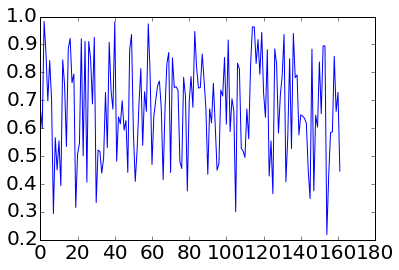

In [137]:
plt.plot(Aes4[:,16])
plt.show()

In [134]:
c1 = np.random.choice(len(Aes1), 100)
sampledAesC1 = Aes1[c1]

c2 = np.random.choice(len(Aes2), 100)
sampledAesC2 = Aes2[c2]

c3 = np.random.choice(len(Aes3), 100)
sampledAesC3 = Aes3[c3]

c4 = np.random.choice(len(Aes4), 100)
sampledAesC4 = Aes4[c4]

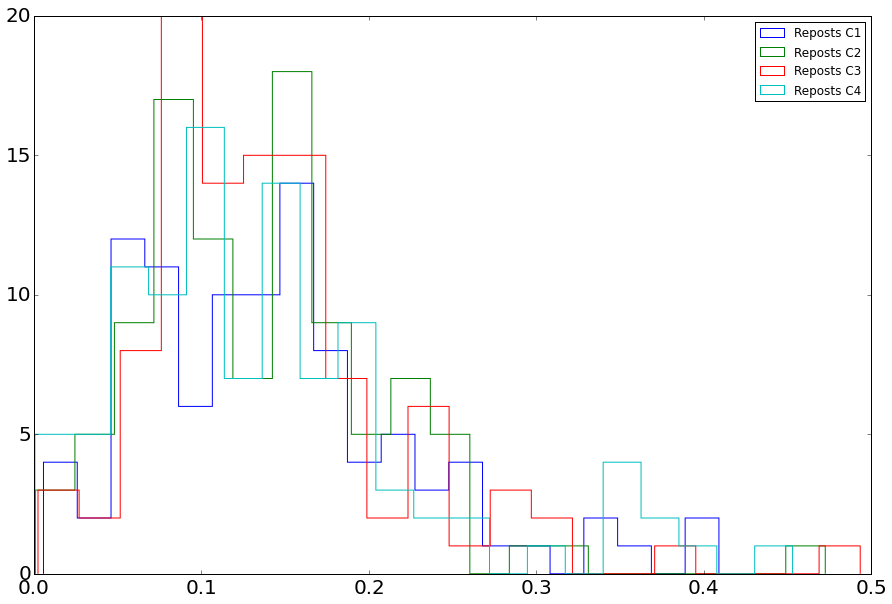

In [135]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.hist(sampledAesC1[:,12], 20, normed=0,histtype='step', cumulative=False, linewidth = 1.0)
plt.hist(sampledAesC2[:,12], 20, normed=0,histtype='step', cumulative=False, linewidth = 1.0)
plt.hist(sampledAesC3[:,12], 20, normed=0,histtype='step', cumulative=False, linewidth = 1.0)
plt.hist(sampledAesC4[:,12], 20, normed=0,histtype='step', cumulative=False, linewidth = 1.0)
plt.legend(['Reposts C1', 'Reposts C2' , 'Reposts C3' , 'Reposts C4', 'Reposts C5'])
plt.show()